In [2]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import numpy as np


from tqdm import tqdm
from typing import Callable, Tuple

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.losses_utils import reduce_weighted_loss

from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

from tensorflow.keras import layers, models



In [3]:
def parse_tfrecord(serialized_example):
    """
    Парсит одну запись из TFRecord файла.

    Args:
        serialized_example: Сериализованная запись TFRecord.

    Returns:
        tuple: Кортеж (inputs, labels) в виде TensorFlow тензоров.
    """
    feature_description = {
        'inputs': tf.io.FixedLenFeature([32, 32, 12], tf.float32),  # Формат inputs: 32x32x12
        'labels': tf.io.FixedLenFeature([32, 32, 1], tf.float32)   # Формат labels: 32x32x1
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    inputs = tf.reshape(example['inputs'], [32, 32, 12])  # Изменяем форму для inputs
    labels = tf.reshape(example['labels'], [32, 32, 1])   # Изменяем форму для labels
    return inputs, labels


def load_tfrecord_dataset(file_path, batch_size):
    """
    Загружает датасет из TFRecord файла и возвращает его как tf.data.Dataset.

    Args:
        file_path (str): Путь к TFRecord файлу.
        batch_size (int): Размер батча.

    Returns:
        tf.data.Dataset: Датасет для обучения или оценки.
    """
    dataset = tf.data.TFRecordDataset(file_path)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


# Путь к вашему TFRecord файлу
tfrecord_path = "filtered_dataset.tfrecord"

# Размер батча
batch_size = 16

# Загрузка датасета
filtered_dataset = load_tfrecord_dataset(tfrecord_path, batch_size)

# Пример использования: выводим размеры первого батча
for inputs, labels in filtered_dataset.take(1):
    print(f"Shape of inputs: {inputs.shape}")
    print(f"Shape of labels: {labels.shape}")

Shape of inputs: (16, 32, 32, 12)
Shape of labels: (16, 32, 32, 1)


In [4]:
def split_dataset(dataset, val_fraction=0.1, test_fraction=0.1, shuffle_buffer_size=1000):
    """
    Делит датасет на обучающий, валидационный и тестовый.

    Args:
        dataset (tf.data.Dataset): Исходный датасет.
        val_fraction (float): Доля данных для валидации.
        test_fraction (float): Доля данных для тестирования.
        shuffle_buffer_size (int): Размер буфера для перемешивания.

    Returns:
        tuple: Кортеж из трех датасетов (train_dataset, val_dataset, test_dataset).
    """
    # Подсчёт общего числа примеров
    dataset_size = sum(1 for _ in dataset)
    
    # Определяем размеры выборок
    val_size = int(dataset_size * val_fraction)
    test_size = int(dataset_size * test_fraction)

    # Перемешивание датасета
    dataset = dataset.shuffle(shuffle_buffer_size, reshuffle_each_iteration=False)

    # Разделение датасета
    val_dataset = dataset.take(val_size)
    test_dataset = dataset.skip(val_size).take(test_size)

    return val_dataset, test_dataset


# Разделяем filtered_dataset
validation_dataset, test_dataset = split_dataset(filtered_dataset, val_fraction=0.1, test_fraction=0.1)


In [5]:
BATCH_SIZE = 16

In [6]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

In [7]:
def plot_samples_from_dataset1(dataset: tf.data.Dataset, n_rows: int):
    """
    Plot 'n_rows' rows of samples from dataset.
    
    Args:
        dataset (Dataset): Dataset from which to plot samples.
        n_rows (int): Number of rows to plot.
    """
    global TITLES
    
    # Get batch
    inputs, labels = None, None
    for elem in dataset:
        inputs, labels = elem
        break
    
    fig = plt.figure(figsize=(15,6.5))

    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    # Number of data variables
    n_features = 12
    for i in range(n_rows):
        for j in range(n_features + 1):
            plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
            if i == 0:
                plt.title(TITLES[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(inputs[i, :, :, j], cmap='viridis')
            if j == n_features - 1:
                plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
            plt.axis('off')
    plt.tight_layout()

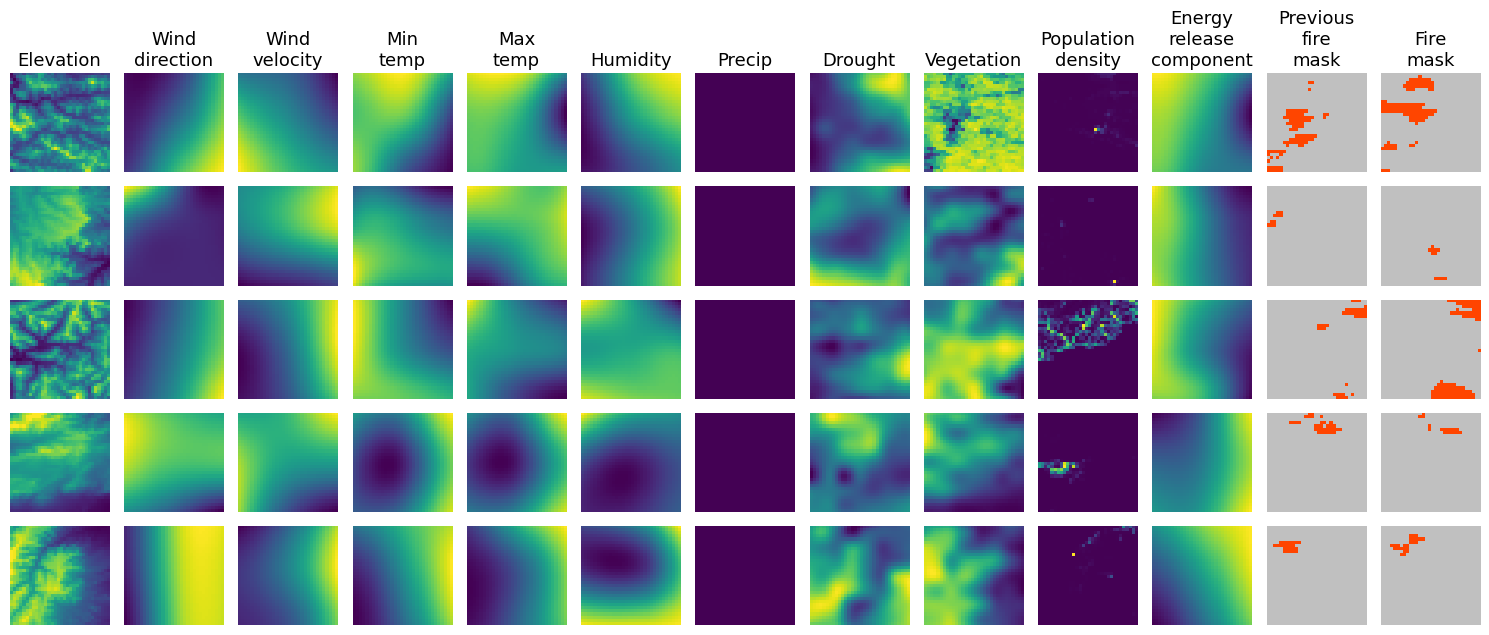

In [7]:
plot_samples_from_dataset1(filtered_dataset, 5)

In [98]:
k = 0
for i in filtered_dataset:
    k += 1
print(k)

2821


In [7]:
def IoU_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of intersection over union metric.
    
    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): IoU metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)
    
    intersection = np.logical_and(real_mask, predicted_mask)
    union = np.logical_or(real_mask, predicted_mask)
    
    if np.sum(union) == 0:
        return 1
    return np.sum(intersection) / np.sum(union)

def recall_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of recall metric.
    
    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): recall metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)
    
    true_positives = np.sum(np.logical_and(real_mask, predicted_mask))
    actual_positives = np.sum(real_mask)
    if actual_positives == 0:
        return 1
    
    return true_positives / actual_positives

def precision_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of precision metric.
    
    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): precision metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)
    
    true_positives = np.sum(np.logical_and(real_mask, predicted_mask))
    predicted_positives = np.sum(predicted_mask)
    if predicted_positives == 0:
        return 1
    
    return true_positives / predicted_positives

In [8]:
def dice_coef(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Dice loss function calculator.
    
    Args:
        y_true (Tensor): 
        y_pred (Tensor):
    Returns:
        (Tensor): Dice loss for each element of a batch.
    """
    smooth = 1e-6
    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    intersection = K.sum(y_true_f * y_pred_f, axis=1)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f, axis=1) + K.sum(y_pred_f, axis=1) + smooth)

def weighted_bincrossentropy(true: tf.Tensor, pred: tf.Tensor, weight_zero: float = 0.01, weight_one: float = 1) -> float:
    """
    Calculates weighted binary cross entropy. The weights are fixed.
        
    This can be useful for unbalanced catagories.
    
    Adjust the weights here depending on what is required.
    
    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives 
        will be penalize 10 times as much as false negatives.
    
    Args:
        true (Tensor): Ground-truth values
        pred (Tensor): Predited values
        weight_zero (float): Weight of class 0 (no-fire)
        weight_one (float): Weight of class 1 (fire)
        
    """
  
    # calculate the binary cross entropy
    bin_crossentropy = K.binary_crossentropy(true, pred)
    
    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy 
    
    return K.mean(weighted_bin_crossentropy, axis=1)

def bce_dice_loss(y_true: tf.Tensor, y_pred: tf.Tensor):
    """
    BCE loss function calculator.
    
    Args:
        y_true (Tensor): 
        y_pred (Tensor):
    Returns:
        (Tensor): Mean BCE Dice loss over a batch.
    """
    
    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    return reduce_weighted_loss(weighted_bincrossentropy(y_true_f, y_pred_f) + dice_coef(y_true, y_pred))

In [10]:
import contextlib

def evaluate_model(prediction_function: Callable[[tf.Tensor], tf.Tensor],
                   eval_dataset: tf.data.Dataset) -> Tuple[float, float, float, float]:
    """
    Loads dataset according to file pattern and evaluates model's predictions on it.
    
    Parameters:
        model (Callable[[tf.Tensor], tf.Tensor]): Function for model inference.
        eval_dataset (tf.dataDataset): Dataset for evaluation.
    
    Returns:
        Tuple[float, float, float, float]: IoU score, recall score, precision score and mean loss.
    """
    IoU_measures = []
    recall_measures = []
    precision_measures = []
    losses = []
    
    for inputs, labels in tqdm(eval_dataset, disable=True):
        # Prediction shape (N, W, H)
        predictions = prediction_function(inputs)
        for i in range(inputs.shape[0]):
            IoU_measures.append(IoU_metric(labels[i, :, :,  0], predictions[i, :, :]))
            recall_measures.append(recall_metric(labels[i, :, :,  0], predictions[i, :, :]))
            precision_measures.append(precision_metric(labels[i, :, :,  0], predictions[i, :, :]))
        labels_cleared = tf.where(labels < 0, 0, labels)
        losses.append(bce_dice_loss(labels_cleared, tf.expand_dims(tf.cast(predictions, tf.float32), axis=-1)))
            
    mean_IoU = np.mean(IoU_measures)
    mean_recall = np.mean(recall_measures)
    mean_precision = np.mean(precision_measures)
    mean_loss = np.mean(losses)
    return mean_IoU, mean_recall, mean_precision, mean_loss

In [12]:
from tensorflow_examples.models.pix2pix import pix2pix

In [13]:

def bce_dice_loss(y_true: tf.Tensor, y_pred: tf.Tensor):
    """
    BCE loss function calculator.
    
    Args:
        y_true (Tensor): 
        y_pred (Tensor):
    Returns:
        (Tensor): Mean BCE Dice loss over a batch.
    """
    
    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    return reduce_weighted_loss(weighted_bincrossentropy(y_true_f, y_pred_f) + dice_coef(y_true, y_pred))



In [13]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_high_accuracy_CNN_AE_model() -> Model:
    """
    Create a high-accuracy CNN autoencoder for fire spread prediction.
    
    Returns:
        (Model): Keras model.
    """
    inputs = layers.Input(shape=(32, 32, 12))  # Входное изображение 32x32 с 12 каналами

    # Encoder
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 32x32 -> 16x16

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 16x16 -> 8x8

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 8x8 -> 4x4

    # Bottleneck
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Decoder
    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 4x4 -> 8x8
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 8x8 -> 16x16
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 16x16 -> 32x32
    x = layers.BatchNormalization()(x)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)  # 32x32 -> 32x32

    return Model(inputs=inputs, outputs=outputs)

# Создание модели
high_accuracy_model = build_high_accuracy_CNN_AE_model()
high_accuracy_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 12)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        6976      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512   

In [26]:
from tqdm import tqdm
def train_model(model: Model, train_dataset: tf.data.Dataset, epochs: int = 10) -> Tuple[List[float], List[float]]:
    """
    Trains a model using train dataset. (Save weights of model with best IoU)
    
    Args:
        model (Model): Model to train.
        train_dataset (Dataset): Training dataset.
        epochs (int): Number of epochs
    Returns:
        Tuple[List[float], List[float]]: Train losses and Validation losses
    """
    loss_fn = bce_dice_loss
    optimizer = tf.keras.optimizers.Adam()
    batch_losses = []
    val_losses = []
    best_IoU = 0.0
    
    for epoch in range(epochs):
        losses = []
        print(f'Epoch {epoch + 1}/{epochs}')
        
        progress = tqdm(train_dataset, disable=False, desc=f'Epoch {epoch+1}')
        
        for images, masks in progress:
            with tf.GradientTape() as tape:
                predictions = model(images, training=True)
                label = tf.where(masks < 0, 0, masks)
                loss = loss_fn(label, predictions)
                losses.append(loss.numpy())
            
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            

            progress.set_postfix({'batch_loss': np.mean(losses)})
        
        avg_loss = np.mean(losses)

        print("Evaluation...")
        IoU, recall, precision, val_loss = evaluate_model(lambda x: tf.where(model.predict(x, verbose=0) > 0.5, 1, 0)[:,:,:,0], validation_dataset)
        print("Validation set metrics:")
        print(f"Mean IoU: {IoU}\nMean precision: {precision}\nMean recall: {recall}\nValidation loss: {val_loss}\n")
        
        if IoU > best_IoU:
            best_IoU = IoU
            model.save_weights("best.h5")
        
        print(f'Epoch {epoch+1} - Train loss: {avg_loss}')
        batch_losses.append(avg_loss)
        val_losses.append(val_loss)
    
    print(f"Best model IoU: {best_IoU}")
    return batch_losses, val_losses



In [ ]:
train_losses, val_losses = train_model(loaded_model1, filtered_dataset, epochs=50)

In [17]:
high_accuracy_model.save('high_accuracy_CNN_AE_model_50_epoch.h5')


In [22]:
from tensorflow.keras.models import load_model
loaded_model1 = load_model("high_accuracy_CNN_AE_model_50_epoch.h5")


In [30]:
train_losses, val_losses = train_model(loaded_model1, filtered_dataset, epochs=25)

Epoch 1/25


Epoch 1: 2821it [02:46, 16.99it/s, batch_loss=0.409]


Evaluation...
Validation set metrics:
Mean IoU: 0.325414938138274
Mean precision: 0.5156628277879611
Mean recall: 0.5030309770230459
Validation loss: 0.8020001649856567

Epoch 1 - Train loss: 0.4091613292694092
Epoch 2/25


Epoch 2: 2821it [02:13, 21.07it/s, batch_loss=0.403]


Evaluation...
Validation set metrics:
Mean IoU: 0.3319231265337704
Mean precision: 0.5097290671980961
Mean recall: 0.5245870162581555
Validation loss: 0.7753052115440369

Epoch 2 - Train loss: 0.4030126631259918
Epoch 3/25


Epoch 3: 2821it [01:44, 26.87it/s, batch_loss=0.4]  


Evaluation...
Validation set metrics:
Mean IoU: 0.33642037981857376
Mean precision: 0.5049893474306258
Mean recall: 0.538410179039608
Validation loss: 0.7635738849639893

Epoch 3 - Train loss: 0.40038907527923584
Epoch 4/25


Epoch 4: 2821it [01:47, 26.16it/s, batch_loss=0.397]


Evaluation...
Validation set metrics:
Mean IoU: 0.33176682091326265
Mean precision: 0.5232228146517856
Mean recall: 0.520023375612707
Validation loss: 0.7759498953819275

Epoch 4 - Train loss: 0.3965420424938202
Epoch 5/25


Epoch 5: 2821it [01:46, 26.52it/s, batch_loss=0.393]


Evaluation...
Validation set metrics:
Mean IoU: 0.3325249805099067
Mean precision: 0.5245516841208451
Mean recall: 0.5186558447980315
Validation loss: 0.7771404385566711

Epoch 5 - Train loss: 0.3932356834411621
Epoch 6/25


Epoch 6: 2821it [01:49, 25.70it/s, batch_loss=0.39] 


Evaluation...
Validation set metrics:
Mean IoU: 0.3326970768252689
Mean precision: 0.5167927147129514
Mean recall: 0.513885843788277
Validation loss: 0.7906395196914673

Epoch 6 - Train loss: 0.3900229036808014
Epoch 7/25


Epoch 7: 2821it [01:52, 25.15it/s, batch_loss=0.386]


Evaluation...
Validation set metrics:
Mean IoU: 0.3333227522934732
Mean precision: 0.5134847378855926
Mean recall: 0.5284666138949482
Validation loss: 0.771393895149231

Epoch 7 - Train loss: 0.38640832901000977
Epoch 8/25


Epoch 8: 2821it [01:51, 25.37it/s, batch_loss=0.385]


Evaluation...
Validation set metrics:
Mean IoU: 0.33063803577298695
Mean precision: 0.5378343366860459
Mean recall: 0.4928165054431576
Validation loss: 0.8018471598625183

Epoch 8 - Train loss: 0.38487881422042847
Epoch 9/25


Epoch 9: 2821it [01:55, 24.52it/s, batch_loss=0.38] 


Evaluation...
Validation set metrics:
Mean IoU: 0.3371191496368372
Mean precision: 0.5281691416452989
Mean recall: 0.5151337145885837
Validation loss: 0.7763141393661499

Epoch 9 - Train loss: 0.3803854286670685
Epoch 10/25


Epoch 10: 2821it [01:44, 26.94it/s, batch_loss=0.378]


Evaluation...
Validation set metrics:
Mean IoU: 0.334949960056909
Mean precision: 0.5357207610607166
Mean recall: 0.5050713991698133
Validation loss: 0.7919819355010986

Epoch 10 - Train loss: 0.37769243121147156
Epoch 11/25


Epoch 11: 2821it [01:44, 26.87it/s, batch_loss=0.374]


Evaluation...
Validation set metrics:
Mean IoU: 0.3346864052257542
Mean precision: 0.5149138726227227
Mean recall: 0.5230354022126029
Validation loss: 0.7751721143722534

Epoch 11 - Train loss: 0.37437471747398376
Epoch 12/25


Epoch 12: 2821it [01:45, 26.70it/s, batch_loss=0.374]


Evaluation...
Validation set metrics:
Mean IoU: 0.3255312564996974
Mean precision: 0.52969103611624
Mean recall: 0.4881726535964365
Validation loss: 0.8106894493103027

Epoch 12 - Train loss: 0.37368783354759216
Epoch 13/25


Epoch 13: 2821it [01:46, 26.58it/s, batch_loss=0.37] 


Evaluation...
Validation set metrics:
Mean IoU: 0.33415417086913707
Mean precision: 0.5387975786341169
Mean recall: 0.5045163613766237
Validation loss: 0.7929884195327759

Epoch 13 - Train loss: 0.37028759717941284
Epoch 14/25


Epoch 14: 2821it [01:46, 26.41it/s, batch_loss=0.365]


Evaluation...
Validation set metrics:
Mean IoU: 0.33176742713688884
Mean precision: 0.5388701307418748
Mean recall: 0.4951030401480245
Validation loss: 0.7985710501670837

Epoch 14 - Train loss: 0.36494407057762146
Epoch 15/25


Epoch 15: 2821it [01:46, 26.40it/s, batch_loss=0.364]


Evaluation...
Validation set metrics:
Mean IoU: 0.3296072198423035
Mean precision: 0.5467728550800846
Mean recall: 0.493575521251051
Validation loss: 0.7995103597640991

Epoch 15 - Train loss: 0.36364084482192993
Epoch 16/25


Epoch 16: 2821it [01:45, 26.76it/s, batch_loss=0.361]


Evaluation...
Validation set metrics:
Mean IoU: 0.33168579609780696
Mean precision: 0.5388773658812849
Mean recall: 0.5031680802093677
Validation loss: 0.7903886437416077

Epoch 16 - Train loss: 0.3608669638633728
Epoch 17/25


Epoch 17: 2821it [01:45, 26.64it/s, batch_loss=0.358]


Evaluation...
Validation set metrics:
Mean IoU: 0.3305131606422026
Mean precision: 0.5372457494224484
Mean recall: 0.4949436219512703
Validation loss: 0.8018465042114258

Epoch 17 - Train loss: 0.35848307609558105
Epoch 18/25


Epoch 18: 2821it [01:44, 26.98it/s, batch_loss=0.356]


Evaluation...
Validation set metrics:
Mean IoU: 0.34204649452414454
Mean precision: 0.5476617988479754
Mean recall: 0.5108742954755452
Validation loss: 0.776720404624939

Epoch 18 - Train loss: 0.3561948537826538
Epoch 19/25


Epoch 19: 2821it [01:46, 26.51it/s, batch_loss=0.353]


Evaluation...
Validation set metrics:
Mean IoU: 0.33508735045620025
Mean precision: 0.5471168026066073
Mean recall: 0.5030289437548531
Validation loss: 0.7878937721252441

Epoch 19 - Train loss: 0.3529726266860962
Epoch 20/25


Epoch 20: 2821it [01:45, 26.80it/s, batch_loss=0.35] 


Evaluation...
Validation set metrics:
Mean IoU: 0.3339097977960496
Mean precision: 0.5566635460245807
Mean recall: 0.48771203597003904
Validation loss: 0.7943655252456665

Epoch 20 - Train loss: 0.35046494007110596
Epoch 21/25


Epoch 21: 2821it [01:45, 26.80it/s, batch_loss=0.347]


Evaluation...
Validation set metrics:
Mean IoU: 0.3402592759315763
Mean precision: 0.5543928474005456
Mean recall: 0.5030852974996297
Validation loss: 0.7809284925460815

Epoch 21 - Train loss: 0.3472641706466675
Epoch 22/25


Epoch 22: 2821it [01:45, 26.82it/s, batch_loss=0.344]


Evaluation...
Validation set metrics:
Mean IoU: 0.32976806358928185
Mean precision: 0.5606952191112872
Mean recall: 0.4843751924528199
Validation loss: 0.8089247345924377

Epoch 22 - Train loss: 0.34446433186531067
Epoch 23/25


Epoch 23: 2821it [01:45, 26.73it/s, batch_loss=0.344]


Evaluation...
Validation set metrics:
Mean IoU: 0.3326617231397858
Mean precision: 0.539398577013945
Mean recall: 0.5053844252073049
Validation loss: 0.7852760553359985

Epoch 23 - Train loss: 0.3442593514919281
Epoch 24/25


Epoch 24: 2821it [01:45, 26.73it/s, batch_loss=0.341]


Evaluation...
Validation set metrics:
Mean IoU: 0.33958326868556166
Mean precision: 0.557553357787553
Mean recall: 0.5001682668301575
Validation loss: 0.7797086834907532

Epoch 24 - Train loss: 0.3406843841075897
Epoch 25/25


Epoch 25: 2821it [01:48, 26.11it/s, batch_loss=0.34] 


Evaluation...
Validation set metrics:
Mean IoU: 0.3378334732625907
Mean precision: 0.5636321514969762
Mean recall: 0.4987836778902427
Validation loss: 0.7851158976554871

Epoch 25 - Train loss: 0.3398503363132477
Best model IoU: 0.34204649452414454


In [36]:
def show_inference_new(
    n_rows: int, dataset: tf.data.Dataset, prediction_function: Callable[[tf.Tensor], tf.Tensor]
) -> None:
    """
    Show model inference through images, iterating through the dataset if needed.
    
    Args:
        n_rows (int): Number of rows for subplots.
        dataset (tf.data.Dataset): Dataset to iterate through.
        prediction_function (Callable[[tf.Tensor], tf.Tensor]): Function for model prediction.
    """
    # Variables for controlling the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    
    fig = plt.figure(figsize=(15, n_rows * 5))
    
    rows_displayed = 0  # Counter to track displayed rows
    for features, labels in dataset:
        # Generate predictions
        predictions = prediction_function(features)
        
        for i in range(features.shape[0]):
            if rows_displayed >= n_rows:
                break  # Stop once we've displayed enough rows
            
            # Extract matrices
            previous_fire = features[i, :, :, -1]  # Feature matrix
            true_future_fire = labels[i, :, :, 0]  # True future fire matrix
            predicted_fire = predictions[i, :, :]  # Predicted future fire matrix
            
            # Combine matrices
            combined_true_and_previous = np.maximum(previous_fire, true_future_fire)
            combined_predicted_and_previous = np.maximum(previous_fire, predicted_fire)
            
            # Plot original matrices
            plt.subplot(n_rows, 5, rows_displayed * 5 + 1)
            plt.title("Previous fire")
            plt.imshow(previous_fire, cmap=CMAP, norm=NORM)
            plt.axis('off')
            
            plt.subplot(n_rows, 5, rows_displayed * 5 + 2)
            plt.title("True future fire")
            plt.imshow(true_future_fire, cmap=CMAP, norm=NORM)
            plt.axis('off')
            
            plt.subplot(n_rows, 5, rows_displayed * 5 + 3)
            plt.title("Predicted future fire")
            plt.imshow(predicted_fire, cmap=CMAP, norm=NORM)
            plt.axis('off')
            
            # Plot combined matrices
            plt.subplot(n_rows, 5, rows_displayed * 5 + 4)
            plt.title("Combined True + Previous")
            plt.imshow(combined_true_and_previous, cmap=CMAP, norm=NORM)
            plt.axis('off')
            
            plt.subplot(n_rows, 5, rows_displayed * 5 + 5)
            plt.title("Combined Predicted + Previous")
            plt.imshow(combined_predicted_and_previous, cmap=CMAP, norm=NORM)
            plt.axis('off')
            
            rows_displayed += 1
        
        if rows_displayed >= n_rows:
            break  # Exit the outer loop if enough rows are displayed
    
    plt.tight_layout()
    plt.show()


In [34]:
import numpy as np

# Настроить вывод NumPy для отображения всех элементов
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

def show_inference_matrices_full(
    n_rows: int, dataset: tf.data.Dataset, prediction_function: Callable[[tf.Tensor], tf.Tensor]
) -> None:
    """
    Show model inference with full numerical matrices.

    Args:
        n_rows (int): Number of rows (examples) to display.
        dataset (tf.data.Dataset): Dataset to iterate through.
        prediction_function (Callable[[tf.Tensor], tf.Tensor]): Function for model prediction.
    """
    rows_displayed = 0  # Counter to track displayed rows

    for features, labels in dataset:
        # Generate predictions
        predictions = prediction_function(features)

        for i in range(features.shape[0]):
            if rows_displayed >= n_rows:
                break  # Stop once we've displayed enough rows
            
            print(f"Example {rows_displayed + 1}:")
            print("Previous day fire (Input):")
            print(list(features[i, :, :, -1].numpy()))  # Convert tensor to numpy array for readability
            
            print("\nTrue next day fire (Label):")
            print(list(labels[i, :, :, 0].numpy()))  # Convert tensor to numpy array
            
            print("\nPredicted next day fire (Prediction):")
            print(list(predictions[i, :, :].numpy()))  # Convert tensor to numpy array
            
            print("-" * 50)  # Separator for better readability
            rows_displayed += 1
        
        if rows_displayed >= n_rows:
            break  # Exit the outer loop if enough rows are displayed


In [33]:
show_inference_matrices(
    n_rows=1,
    dataset=test_dataset,
    prediction_function=lambda x: tf.where(segmentation_model.predict(x) > 0.5, 1, 0)[:, :, :, 0]
)

1/1 [==============================] - 0s 26ms/step
Example 1:
Previous day fire (Input):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.

In [42]:
import numpy as np
import tensorflow as tf
from typing import Callable

# Настроить вывод NumPy для отображения всех элементов
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

def show_inference_matrices_full(
    n_rows: int, dataset: tf.data.Dataset, prediction_function: Callable[[tf.Tensor], tf.Tensor]
) -> None:
    """
    Show model inference with full numerical matrices and return the results as arrays.

    Args:
        n_rows (int): Number of rows (examples) to display.
        dataset (tf.data.Dataset): Dataset to iterate through.
        prediction_function (Callable[[tf.Tensor], tf.Tensor]): Function for model prediction.
    """
    rows_displayed = 0  # Counter to track displayed rows
    results = []  # Список для хранения результатов

    for features, labels in dataset:
        # Generate predictions
        predictions = prediction_function(features)

        for i in range(features.shape[0]):
            if rows_displayed >= n_rows:
                break  # Stop once we've displayed enough rows
            
            # Сохранение данных в результаты
            input_matrix = features[i, :, :, -1].numpy()  # Преобразуем в NumPy массив для удобства
            label_matrix = labels[i, :, :, 0].numpy()
            prediction_matrix = predictions[i, :, :].numpy()
            combined_true_and_previous = np.maximum(input_matrix, label_matrix)
            combined_predicted_and_previous = np.maximum(input_matrix, prediction_matrix)
            
            # Добавляем все три матрицы в результаты
            results.append((input_matrix, combined_true_and_previous, combined_predicted_and_previous))
            
            rows_displayed += 1
        
        if rows_displayed >= n_rows:
            break  # Exit the outer loop if enough rows are displayed
    
    # Возвращаем все собранные результаты
    return results

# Пример использования:
result_matrices = show_inference_matrices_full(
    n_rows=100,
    dataset=filtered_dataset,
    prediction_function=lambda x: tf.where(loaded_model1.predict(x) > 0.5, 1, 0)[:, :, :, 0]
)

# Вывод всех матриц через цикл:
for idx, (input_matrix, label_matrix, prediction_matrix) in enumerate(result_matrices):
    if(idx == 60):
        print(f"Example {idx + 1}:")
        print("Previous day fire (Input):")
    #     print(input_matrix)
        for i in input_matrix:
            print('[', end = "")
            for j in i:
                print(j, ',', end = "")
            print('],')
        
        print("\nTrue next day fire (Label):")
        for i in label_matrix:
            print('[', end = "")
            for j in i:
                print(j, ',', end = "")
            print('],')
        
        print("\nPredicted next day fire (Prediction):")
        for i in prediction_matrix:
            print('[', end = "")
            for j in i:
                print(j, ',', end = "")
            print('],')
        
    #     print("-" * 50)  # Разделитель для лучшего восприятия


1/1 [==============================] - 0s 60ms/step
Example 61:
Previous day fire (Input):
[0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,],
[0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,],
[0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,],
[0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,],
[0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,],
[0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0

In [38]:
#модель на 50 эпох, предсказывает пока не отлично
show_inference_new(
    n_rows=100,
    dataset=filtered_dataset,
    prediction_function=lambda x: tf.where(loaded_model1.predict(x) > 0.5, 1, 0)[:, :, :, 0]
)

1/1 [==============================] - 0s 17ms/step


In [40]:
loaded_model1.save('high_accuracy_CNN_AE_model_75_epoch.h5')


Тут у нас уже модель на 100 эпох, конечная тренировка

In [42]:
train_losses, val_losses = train_model(loaded_model1, filtered_dataset, epochs=25)

Epoch 1/25


Epoch 1: 2821it [01:45, 26.64it/s, batch_loss=0.337]


Evaluation...
Validation set metrics:
Mean IoU: 0.3378518082137999
Mean precision: 0.5457147779123864
Mean recall: 0.5024794652513838
Validation loss: 0.7869377136230469

Epoch 1 - Train loss: 0.33738869428634644
Epoch 2/25


Epoch 2: 2821it [01:45, 26.76it/s, batch_loss=0.333]


Evaluation...
Validation set metrics:
Mean IoU: 0.3390617127365236
Mean precision: 0.5628105202916479
Mean recall: 0.4995142367778605
Validation loss: 0.7801293134689331

Epoch 2 - Train loss: 0.3328360617160797
Epoch 3/25


Epoch 3: 2821it [01:45, 26.75it/s, batch_loss=0.331]


Evaluation...
Validation set metrics:
Mean IoU: 0.3396486673765774
Mean precision: 0.5547972034392208
Mean recall: 0.500980241295121
Validation loss: 0.7826352715492249

Epoch 3 - Train loss: 0.33125045895576477
Epoch 4/25


Epoch 4: 2821it [01:44, 27.03it/s, batch_loss=0.331]


Evaluation...
Validation set metrics:
Mean IoU: 0.3357133946134997
Mean precision: 0.5593470883911479
Mean recall: 0.48877904094358743
Validation loss: 0.7979217767715454

Epoch 4 - Train loss: 0.3313053548336029
Epoch 5/25


Epoch 5: 2821it [01:45, 26.68it/s, batch_loss=0.328]


Evaluation...
Validation set metrics:
Mean IoU: 0.3443049462768735
Mean precision: 0.5543419392481829
Mean recall: 0.50576980485961
Validation loss: 0.7791032791137695

Epoch 5 - Train loss: 0.3280579149723053
Epoch 6/25


Epoch 6: 2821it [01:45, 26.75it/s, batch_loss=0.323]


Evaluation...
Validation set metrics:
Mean IoU: 0.34123845114671875
Mean precision: 0.5793322684726279
Mean recall: 0.49254942029442716
Validation loss: 0.785429060459137

Epoch 6 - Train loss: 0.32340502738952637
Epoch 7/25


Epoch 7: 2821it [01:45, 26.72it/s, batch_loss=0.322]


Evaluation...
Validation set metrics:
Mean IoU: 0.3418566178627385
Mean precision: 0.5709772480471653
Mean recall: 0.49454734950158036
Validation loss: 0.7832551002502441

Epoch 7 - Train loss: 0.32248547673225403
Epoch 8/25


Epoch 8: 2821it [01:46, 26.40it/s, batch_loss=0.32] 


Evaluation...
Validation set metrics:
Mean IoU: 0.34482150728374406
Mean precision: 0.5677446943668398
Mean recall: 0.4973943908362104
Validation loss: 0.780012309551239

Epoch 8 - Train loss: 0.31979063153266907
Epoch 9/25


Epoch 9: 2821it [01:56, 24.23it/s, batch_loss=0.318]


Evaluation...
Validation set metrics:
Mean IoU: 0.34901970842832974
Mean precision: 0.55965139437007
Mean recall: 0.5091650316489666
Validation loss: 0.763911247253418

Epoch 9 - Train loss: 0.31809869408607483
Epoch 10/25


Epoch 10: 2821it [01:54, 24.56it/s, batch_loss=0.317]


Evaluation...
Validation set metrics:
Mean IoU: 0.3423435673399001
Mean precision: 0.5679370926799736
Mean recall: 0.497693216676978
Validation loss: 0.7822962403297424

Epoch 10 - Train loss: 0.31684228777885437
Epoch 11/25


Epoch 11: 2821it [01:57, 23.99it/s, batch_loss=0.315]


Evaluation...
Validation set metrics:
Mean IoU: 0.3407959195911662
Mean precision: 0.5639474788754059
Mean recall: 0.49358020351749404
Validation loss: 0.7832724452018738

Epoch 11 - Train loss: 0.31531310081481934
Epoch 12/25


Epoch 12: 2821it [01:46, 26.45it/s, batch_loss=0.312]


Evaluation...
Validation set metrics:
Mean IoU: 0.3418866154652407
Mean precision: 0.5701005355501706
Mean recall: 0.49609704774140084
Validation loss: 0.7853792309761047

Epoch 12 - Train loss: 0.312463641166687
Epoch 13/25


Epoch 13: 2821it [01:49, 25.66it/s, batch_loss=0.312]


Evaluation...
Validation set metrics:
Mean IoU: 0.34576404796937515
Mean precision: 0.5669931805918101
Mean recall: 0.500430937280325
Validation loss: 0.7791305184364319

Epoch 13 - Train loss: 0.31161507964134216
Epoch 14/25


Epoch 14: 2821it [01:46, 26.55it/s, batch_loss=0.308]


Evaluation...
Validation set metrics:
Mean IoU: 0.3438066708644121
Mean precision: 0.5670967661630463
Mean recall: 0.5023227181378531
Validation loss: 0.783175528049469

Epoch 14 - Train loss: 0.3081915080547333
Epoch 15/25


Epoch 15: 2821it [01:46, 26.40it/s, batch_loss=0.307]


Evaluation...
Validation set metrics:
Mean IoU: 0.34013613190492337
Mean precision: 0.5842668440607944
Mean recall: 0.48447143387622627
Validation loss: 0.7911037802696228

Epoch 15 - Train loss: 0.3066978454589844
Epoch 16/25


Epoch 16: 2821it [01:48, 26.10it/s, batch_loss=0.306]


Evaluation...
Validation set metrics:
Mean IoU: 0.34065210495099146
Mean precision: 0.5780066913706136
Mean recall: 0.49286567488895566
Validation loss: 0.7869071960449219

Epoch 16 - Train loss: 0.3062075674533844
Epoch 17/25


Epoch 17: 2821it [01:46, 26.41it/s, batch_loss=0.303]


Evaluation...
Validation set metrics:
Mean IoU: 0.3397264229911048
Mean precision: 0.5767867119391368
Mean recall: 0.48907567311206185
Validation loss: 0.7917096018791199

Epoch 17 - Train loss: 0.3033064901828766
Epoch 18/25


Epoch 18: 2821it [01:50, 25.62it/s, batch_loss=0.302]


Evaluation...
Validation set metrics:
Mean IoU: 0.342294109992484
Mean precision: 0.5692513988908117
Mean recall: 0.4929712198217175
Validation loss: 0.7854106426239014

Epoch 18 - Train loss: 0.30155184864997864
Epoch 19/25


Epoch 19: 2821it [01:47, 26.31it/s, batch_loss=0.299]


Evaluation...
Validation set metrics:
Mean IoU: 0.3442116204576509
Mean precision: 0.5759495703713658
Mean recall: 0.49709551601258717
Validation loss: 0.779719352722168

Epoch 19 - Train loss: 0.29938459396362305
Epoch 20/25


Epoch 20: 2821it [01:47, 26.34it/s, batch_loss=0.298]


Evaluation...
Validation set metrics:
Mean IoU: 0.34205618964004836
Mean precision: 0.5773456495419541
Mean recall: 0.4930065912840463
Validation loss: 0.7786696553230286

Epoch 20 - Train loss: 0.2979789972305298
Epoch 21/25


Epoch 21: 2821it [01:47, 26.16it/s, batch_loss=0.296]


Evaluation...
Validation set metrics:
Mean IoU: 0.33550720820536317
Mean precision: 0.5773351706259207
Mean recall: 0.47802133690698123
Validation loss: 0.8024377226829529

Epoch 21 - Train loss: 0.29580482840538025
Epoch 22/25


Epoch 22: 2821it [01:47, 26.30it/s, batch_loss=0.295]


Evaluation...
Validation set metrics:
Mean IoU: 0.3427935111699041
Mean precision: 0.5873669022425796
Mean recall: 0.4886498124792854
Validation loss: 0.7889342904090881

Epoch 22 - Train loss: 0.2946334779262543
Epoch 23/25


Epoch 23: 2821it [01:47, 26.25it/s, batch_loss=0.292]


Evaluation...
Validation set metrics:
Mean IoU: 0.3455496948881891
Mean precision: 0.5886856248900353
Mean recall: 0.4862525334942881
Validation loss: 0.784369707107544

Epoch 23 - Train loss: 0.2923932671546936
Epoch 24/25


Epoch 24: 2821it [01:47, 26.24it/s, batch_loss=0.29] 


Evaluation...
Validation set metrics:
Mean IoU: 0.34256173424264585
Mean precision: 0.6012211155414249
Mean recall: 0.47818844676526623
Validation loss: 0.7901924848556519

Epoch 24 - Train loss: 0.29011210799217224
Epoch 25/25


Epoch 25: 2821it [02:29, 18.92it/s, batch_loss=0.289]


Evaluation...
Validation set metrics:
Mean IoU: 0.34563385608969777
Mean precision: 0.5896949091696851
Mean recall: 0.49119006533294274
Validation loss: 0.781571626663208

Epoch 25 - Train loss: 0.28877073526382446
Best model IoU: 0.34901970842832974


In [62]:
loaded_model1.save('high_accuracy_CNN_AE_model_100_epoch.h5')

In [44]:
#модель на 100 эпох
show_inference_new(
    n_rows=100,
    dataset=filtered_dataset,
    prediction_function=lambda x: tf.where(loaded_model1.predict(x) > 0.5, 1, 0)[:, :, :, 0]
)

1/1 [==============================] - 0s 24ms/step


In [ ]:
def show_inference_matrices_full_last(
    n_rows: int, dataset: tf.data.Dataset, prediction_function: Callable[[tf.Tensor], tf.Tensor]
) -> None:
    """
    Show model inference with full numerical matrices and return the results as arrays.

    Args:
        n_rows (int): Number of rows (examples) to display.
        dataset (tf.data.Dataset): Dataset to iterate through.
        prediction_function (Callable[[tf.Tensor], tf.Tensor]): Function for model prediction.
    """
    rows_displayed = 0  # Counter to track displayed rows
    results = []  # Список для хранения результатов

    for features, labels in dataset:
        # Generate predictions
        predictions = prediction_function(features)

        for i in range(features.shape[0]):
            if rows_displayed >= n_rows:
                break  # Stop once we've displayed enough rows
            
            # Сохранение данных в результаты
            input_matrix = features[i, :, :, -1].numpy()  # Преобразуем в NumPy массив для удобства
            label_matrix = labels[i, :, :, 0].numpy()
            temp_prediction_matrix = predictions[i, :, :].numpy()
            full_true = np.maximum(input_matrix, label_matrix)
            full_predicted = np.maximum(input_matrix, temp_prediction_matrix)
            
            # Добавляем все три матрицы в результаты
            results.append((input_matrix, full_true, full_predicted))
            
            rows_displayed += 1
        
        if rows_displayed >= n_rows:
            break  # Exit the outer loop if enough rows are displayed
    
    # Возвращаем все собранные результаты
    return results

result_matrices = show_inference_matrices_full_last(
    n_rows=100,
    dataset=test_dataset,
    prediction_function=lambda x: tf.where(loaded_model1.predict(x) > 0.5, 1, 0)[:, :, :, 0]
)

In [50]:
def show_inference_matrices_full(
    n_rows: int, dataset: tf.data.Dataset, prediction_function: Callable[[tf.Tensor], tf.Tensor]
) -> None:
    """
    Show model inference with full numerical matrices and return the results as arrays.

    Args:
        n_rows (int): Number of rows (examples) to display.
        dataset (tf.data.Dataset): Dataset to iterate through.
        prediction_function (Callable[[tf.Tensor], tf.Tensor]): Function for model prediction.
    """
    rows_displayed = 0  # Counter to track displayed rows
    results = []  # Список для хранения результатов

    for features, labels in dataset:
        # Generate predictions
        predictions = prediction_function(features)

        for i in range(features.shape[0]):
            if rows_displayed >= n_rows:
                break  # Stop once we've displayed enough rows
            
            # Сохранение данных в результаты
            input_matrix = features[i, :, :, -1].numpy()  # Преобразуем в NumPy массив для удобства
            label_matrix = labels[i, :, :, 0].numpy()
            prediction_matrix = predictions[i, :, :].numpy()
            combined_true_and_previous = np.maximum(input_matrix, label_matrix)
            combined_predicted_and_previous = np.maximum(input_matrix, prediction_matrix)
            
            # Добавляем все три матрицы в результаты
            results.append((input_matrix, combined_true_and_previous, combined_predicted_and_previous))
            
            rows_displayed += 1
        
        if rows_displayed >= n_rows:
            break  # Exit the outer loop if enough rows are displayed
    
    # Возвращаем все собранные результаты
    return results

In [52]:
def calculate_fire_speeds(matrix_start, matrix_end, time_hours):
    """
    Рассчитывает скорость распространения пожара в четырех направлениях, используя только начальную и конечную матрицы.

    :param matrix_start: numpy массив начальной позиции огня (0 и 1).
    :param matrix_end: numpy массив конечной позиции огня (0 и 1).
    :param time_hours: Общее время (в часах), за которое пожар распространялся.
    :return: Скорости распространения в направлениях [вверх, вниз, влево, вправо] (в км/ч).
    """
    rows, cols = matrix_start.shape
    assert matrix_start.shape == matrix_end.shape, "Матрицы должны быть одинакового размера"

    directions = {
        "up": (-1, 0),
        "down": (1, 0),
        "left": (0, -1),
        "right": (0, 1)
    }

    speeds = {key: 0 for key in directions.keys()}
    counts = {key: 0 for key in directions.keys()}

    # Найти новые очаги пожара
    new_fires = np.logical_and(matrix_end == 1, matrix_start == 0)

    for r in range(rows):
        for c in range(cols):
            if new_fires[r, c]:  # Если здесь появился пожар
                for direction, (dr, dc) in directions.items():
                    rr, cc = r + dr, c + dc
                    distance = 0
                    while 0 <= rr < rows and 0 <= cc < cols:
                        if matrix_start[rr, cc] == 1:  # Найден источник огня
                            speeds[direction] += distance + 1  # Учитываем пройденное расстояние
                            counts[direction] += 1
                            break
                        rr += dr
                        cc += dc
                        distance += 1

    # Рассчитываем скорости
    for direction in speeds.keys():
        if counts[direction] > 0:
            speeds[direction] = (speeds[direction] / counts[direction]) / time_hours  # Перевод в км/ч
        else:
            speeds[direction] = 0  # Если огонь не распространялся в этом направлении

    return speeds

In [58]:
import numpy as np
from sklearn.metrics import r2_score

def extract_and_calculate_speeds(result_matrices, time_hours=12):
    """
    Вычисляет скорости распространения пожара для истинных и предсказанных матриц.
    
    :param result_matrices: Список кортежей (input_matrix, true_matrix, predicted_matrix)
    :param time_hours: Время распространения пожара в часах
    :return: Два массива: истинные скорости и предсказанные скорости
    """
    true_speeds = []
    predicted_speeds = []
    count = 0
    for input_matrix, full_true, full_predicted in result_matrices:
        # Рассчитываем скорости для истинной и предсказанной матрицы
        speeds_true = calculate_fire_speeds(input_matrix, full_true, time_hours)
        speeds_pred = calculate_fire_speeds(input_matrix, full_predicted, time_hours)
        
        # Добавляем скорости в общий список
        true_speeds.extend(list(speeds_true.values()))
        predicted_speeds.extend(list(speeds_pred.values()))
            
    
    return np.array(true_speeds), np.array(predicted_speeds)

# Вычисление R^2
def calculate_r2(result_matrices, time_hours=1):
    """
    Рассчитывает R^2 для матриц пожара.
    
    :param result_matrices: Список кортежей (input_matrix, true_matrix, predicted_matrix)
    :param time_hours: Время распространения пожара в часах
    :return: Значение R^2
    """
    true_speeds, predicted_speeds = extract_and_calculate_speeds(result_matrices, time_hours)
    r2 = r2_score(true_speeds, predicted_speeds)
    return r2

def calculate_accuracy(result_matrices, time_hours=1):
    """
    Рассчитывает точность модели в процентах на основе MAPE.
    
    :param result_matrices: Список кортежей (input_matrix, true_matrix, predicted_matrix).
    :param time_hours: Время распространения пожара в часах.
    :return: Точность модели в процентах.
    """
    true_speeds, predicted_speeds = extract_and_calculate_speeds(result_matrices, time_hours)
    
    # Вычисление MAPE (Средняя абсолютная процентная ошибка)
    true_speeds = np.array(true_speeds)
    predicted_speeds = np.array(predicted_speeds)
    
    # Защита от деления на ноль
    nonzero_mask = true_speeds != 0
    mape = np.mean(np.abs((true_speeds[nonzero_mask] - predicted_speeds[nonzero_mask]) / true_speeds[nonzero_mask])) * 100
    
    # Точность как 100% - MAPE
    accuracy = 100 - mape
    return accuracy


# Пример вызова
result_matrices = show_inference_matrices_full(
    n_rows=1000,
    dataset=filtered_dataset,
    prediction_function=lambda x: tf.where(loaded_model1.predict(x) > 0.5, 1, 0)[:, :, :, 0]
)  # Сюда передай свои данные
# print(len(result_matrices))
# for idx, (input_matrix, label_matrix, prediction_matrix) in enumerate(result_matrices):
#     print(f"Example {idx + 1}:")
#     for i in input_matrix:
#             print('[', end = "")
#             for j in i:
#                 print(j, ',', end = "")
#             print('],')
#     print("\nTrue next day fire (Label):")
#     for i in label_matrix:
#         print('[', end = "")
#         for j in i:
#             print(j, ',', end = "")
#         print('],')
    
#     print("\nPredicted next day fire (Prediction):")
#     for i in prediction_matrix:
#         print('[', end = "")
#         for j in i:
#             print(j, ',', end = "")
#         print('],')
r2_value = calculate_r2(result_matrices, time_hours=12)
mape_acc = calculate_accuracy(result_matrices, time_hours=12)
print(f"R^2 модели: {r2_value}")
print(f"MAPE модели: {mape_acc}")

1/1 [==============================] - 0s 20ms/step
R^2 модели: 0.9156644245808847
MAPE модели: 78.02356110820257
